# Audioset

* A Google Drive link is provided with the test and train features for the dataset.

* It is highly recommended to download the features and place them in the "Audioset" folder with the names "Train_Features" and "Eval_Features."

* If you decide to use the provided features, skip everything in the notebook until the Feature Extraction section.

* If you want to do everything from scratch, follow the instructions carefully step by step, preferably on a cloud service.


In [ ]:
import os
directory = "please_add_directory"
os.chdir(directory)

from Scripts import Utilities as ut
from Scripts import Feature_Extraction as fe
from Scripts import Model_Training as mt
from Scripts import data_loading as dl
from Scripts import Audioset_Parser as ap
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output



dataset = "audioset"

# Dowload process

In [ ]:

"""

Essential Procerdures for the dowload to work

Make sure you folloed the steps before importing


"""
# Clone the audioset repository
!git clone https://github.com/lukefahr/audioset.git
%cd audiosetAC
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

In [4]:
from Scripts import Audioset_Downloads as ad

When cloning the directory, a folder called "metadata" will be found inside. Within this folder, there are the "balanced_train_segments" and "eval_segments" CSV files. These files need to be downloaded and the audio segments should be cut from YouTube.

In [ ]:
# change to your own
ad.download_and_cut_audioset("segments_csv", "audioset_dowload_directory")


After downloading, flag the files that were created before the date you started downloading the dataset. This method helps to discriminate which files were correctly cut and which were not. Then, move these flagged files to another directory and cut them based on the CSV files locally.

In [ ]:
""""
All paths are example paths change them with oyur own this is the pipeline of the procedure we follow and you oly need to dowload the Audioset Train and Eval

"""

cutoff_date = datetime(2024, 6, 6).timestamp() # example date
folder_path = "audioset_dowload_directory"

ut.flag_old_files(folder_path, cutoff_date)

ut.move_files_with_prefix(folder_path,"flaged_files_dest", "FLAG-")

ut.delete_files_with_prefix("flaged_files_dest","FLAG-")

ap.cut_audio( "train_segments_csv","flaged_files_dest", "AS_Train") # change for eval

ap.convert_audio(folder_path, "AS_Train")



# Extract Labels

After downloading AS_Train and AS_Eval, extract the labels for the CSV files using the ontology.json located in the GitHub directory mounted at the start. The balanced_train_segments.csv and eval_segments.csv files are also there, but they will be provided locally in the "Audioset\CSVs" directory.

Before starting, add columns for class_1, class_2, class_3, ..., class_12, class_13 to both CSV files. This has been done here, but if you want to replicate it from scratch, you need to add these columns manually.

In [ ]:

input_csv = "Audioset\\CSVs\\balanced_train_segments.csv"
ontology_json = "Audioset\\CSVs\\ontology.json"
output_csv= "Audioset\\CSVs\\balanced_train_labels.csv"
sound_path = "Audioset\\AS_Train"

ap.get_labels(input_csv, ontology_json, output_csv, sound_path)

# Seperate files into class fodler
ut.move_to_class_folder("Audioset\CSVs\GPTTrain.csv","Audioset\AS_Train",dataset)

In [ ]:
input_csv = "Audioset\CSVs\eval_segments.csv"
ontology_json = "Audioset\\CSVs\\ontology.json"
output_csv= "Audioset\\CSVs\\eval_labels.csv"
sound_path = "Audioset\\AS_Eval"

ap.get_labels(input_csv, ontology_json, output_csv, sound_path)

ut.move_to_class_folder("Audioset\CSVs\GPTEval.csv","Audioset\AS_Eval",dataset)

Now that we have the CSV with the files, we initially tried applying NLP methods and clustering to categorize files with similar names into 8 categories. However, our efforts paled in comparison to what GPT-4 achieved. To put it in perspective, our accuracy improved from 20% to 50% using GPT-4, making it essential to use these results. Nevertheless, we have included our attempt in the DL_Project under the Bonus folder because it was a sincere effort.

We will proceed with the GPT-generated labels, which are located in DL_Project\Audioset\CSVs.

We asked GPT to separate our folders into 10 categories, but some categories were oversampled while one was very undersampled (140 files total). For perspective, other folders had between 2,000 to 8,000 files. We made some manual modifications and tests but we ended up with the original split.

# Feature Extraction
The same method used in the UrbanSound8k dataset is applied here.

ATTENTION Name feature folders Train_Features, Eval_Features corespondingly

                            ---------- Uncoment only if you dont have the features and you wan to create them  -------------             

In [ ]:
# # Feature_Extraction

fe.CNN_Features_mel("Audioset\AS_Train", "Audioset\\Train_Features")
fe.CNN_Features_mel("Audioset\AS_Eval",  "Audioset\\Eval_Features")

- If you have the features at the right directory you can load the data and start trainbing your model

In [5]:
x_train, x_val, y_train, y_val, encoder =  dl.load_data("Audioset", dataset)

In [6]:
model = mt.create_model_CNN_AS(num_classes = 8)

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate = learning_rate ), loss='categorical_crossentropy', metrics=[mt.f1_score, 'accuracy'])

early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, verbose=1)

checkpoint = ModelCheckpoint( 'Models\\temp.h5',monitor='val_f1_score', verbose=1,   save_best_only=True, mode='max')

In [ ]:
hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150, callbacks = [early_stopping,checkpoint],
    batch_size=64
    )

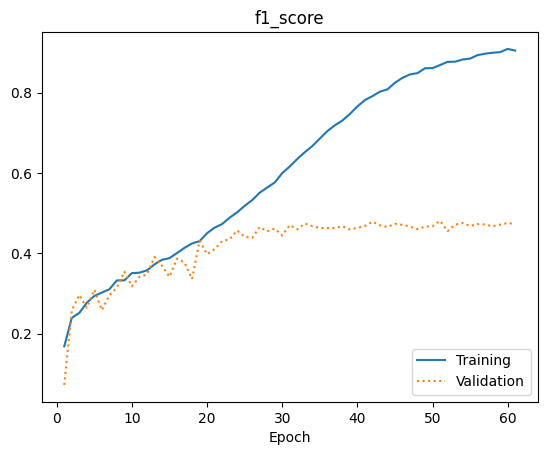

In [11]:
_ = hist.history['f1_score']
c = hist.history['val_f1_score']
mt.plot_training_history(_,c,"f1_score")

518/518 [==============================] - 5s 10ms/step
Accuracy: 0.48828926717372934
F1 Score: 0.47112611138472216


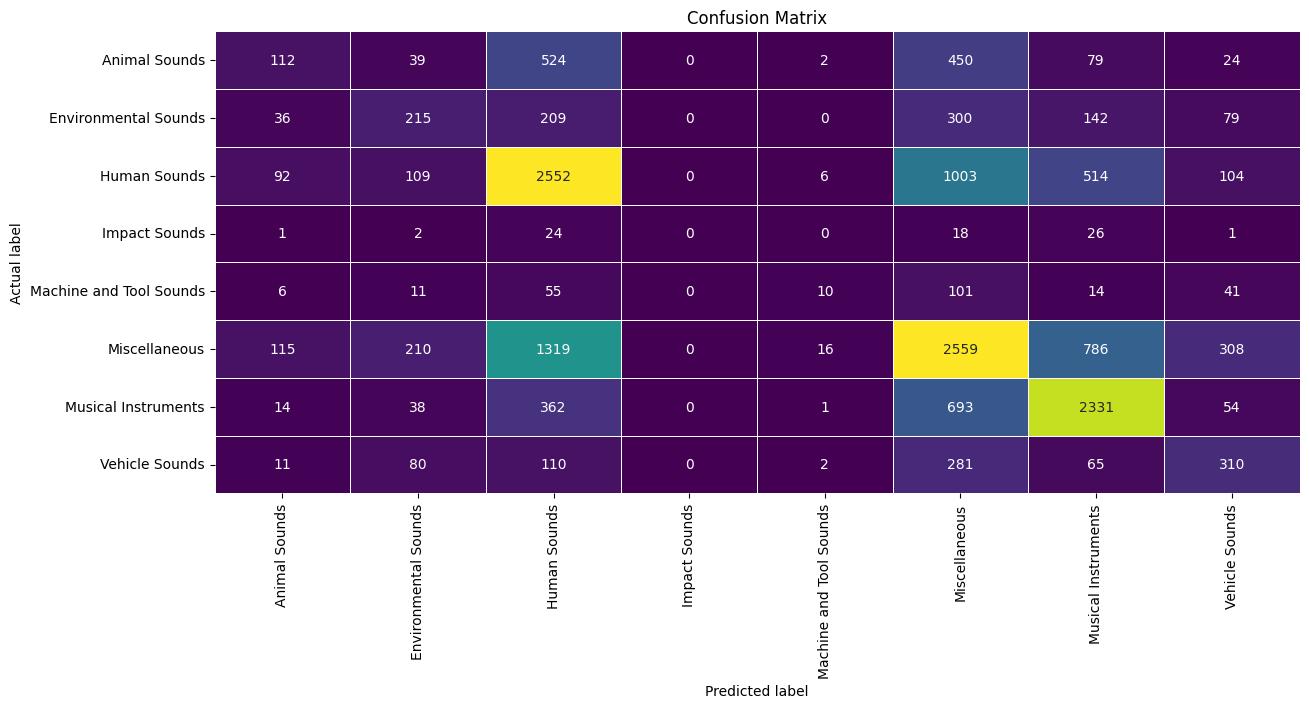

In [14]:
mt.plot_confusion_matrix(model,x_val,y_val,encoder)

In [13]:
model = mt.model_load("Models\\temp.h5")
clear_output()
model.save(f"Models\\CNN_Complex_allf_f_0pad.h5")